In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm

import numpy as np
import pandas as pd  #requirement comes with anaconda
import datetime 
from datetime import datetime as dt
import seaborn as sns
import operator  
import community #requires separate install -  pip install python-louvain
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv("../datasets/citibike/201701-citibike-tripdata.csv.gz", compression='gzip', header=0, sep=',')

In [7]:
df.head(2)

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226,W 82 St & Central Park West,40.782750,-73.971370,3165,Central Park West & W 72 St,40.775794,-73.976206,25542,Subscriber,1965.0,2
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263,Cooper Square & E 7 St,40.729236,-73.990868,498,Broadway & W 32 St,40.748549,-73.988084,21136,Subscriber,1987.0,2


In [8]:
#Helper function to plot networks.
import networkx as nx

def plot_network(g,node_dist=1.0,nodecolor='g',nodesize=1200,nodealpha=0.6,edgecolor='k',\
                 edgealpha=0.2,figsize=(9,6),title=None,titlefontsize=20,savefig=False,\
                 filename=None,bipartite=False,bipartite_colors=None):
    pos=nx.spring_layout(g,k=node_dist)
    nodes=g.nodes()
    edges=g.edges()
    plt.figure(figsize=figsize)
    
    nx.draw_networkx_edges(g,pos=pos,edge_color=edgecolor,alpha=edgealpha)
    #nx.draw_networkx_edges(g,pos=pos,edge_color=edgecolor,alpha=edgealpha)
    if bipartite and bipartite_colors!=None:
        bipartite_sets=nx.bipartite.sets(g)
        _nodecolor=[]
        for _set in bipartite_sets:
            _clr=bipartite_colors.pop()
            for node in _set:
                _nodecolor.append(_clr)

        nx.draw_networkx_nodes(g,pos=pos,node_color=_nodecolor,alpha=nodealpha,node_size=nodesize)
    else:
        nx.draw_networkx_nodes(g,pos=pos,node_color=nodecolor,alpha=nodealpha,node_size=nodesize)

    labels={}
    for idx,node in enumerate(g.nodes()):
        labels[node]=str(node)
    
    #nx.draw_networkx_labels(g,pos,labels,font_size=16)
    plt.xticks([])
    plt.yticks([])
    if title!=None:
        plt.title(title,fontsize=titlefontsize)
    if savefig and filename!=None:
        plt.savefig(filename,dpi=300)

In [9]:
path_to_citibike_dataset="../datasets/citibike/201701-citibike-tripdata.csv.gz"
#read_csv is a built in function in pandas
df = pd.read_csv(path_to_citibike_dataset, compression='gzip', header=0, sep=',')
#convert the Start and End Time columns to datetime.
df['Start Time']=pd.to_datetime(df['Start Time'])
df['Stop Time']=pd.to_datetime(df['Stop Time'])

#Trip Duration is End - Start time. This will result in datetime.timedelta objects, stored in the 'Trip Duration' column.
df['Trip Duration']=df['Stop Time'] - df['Start Time']  #This is still timedelta.

#Convert datetime.timedelta object Trip Duration to floating point number of minutes for ease of plotting.
df['Trip Duration Minutes']=df['Trip Duration'].apply(lambda x: datetime.timedelta.total_seconds(x)/60.0)

#Here we focus on a subset of "interesting" trips with duration between 5 and 120 minutes.
subset_trips=df[(df['Trip Duration Minutes']>5) & (df['Trip Duration Minutes']<120)]

In [10]:
dir_edges=dict()
for s,t,d in zip(df['Start Station ID'].values,df['End Station ID'].values,df['Trip Duration Minutes'].values):
    if s not in dir_edges:
        dir_edges[s]={t:d}
    else:
        try:
            dir_edges[s][t]+=d
        except KeyError:
            dir_edges[s][t]=d

In [11]:
edges_with_weights=list()
weights=list()
for st_stn in dir_edges:  
    end_stns=list(dir_edges[st_stn].keys())   
    num_end_stations=len(end_stns)
    for end_stn in end_stns:
        norm_wt=dir_edges[st_stn][end_stn]/num_end_stations
        edges_with_weights.append({'edge':(st_stn,end_stn),'weight':norm_wt})

In [12]:
#edges[:len(weights)*0.3]
g=nx.DiGraph() #Instantiate a Directed Graph Object from NetworkX.
thr=0.005 #Get top 0.5% edges by weight.
edges_with_weights_new=list(filter(lambda edg: edg['edge'][0]!=edg['edge'][1],
                               sorted(edges_with_weights,reverse=True,
                                      key=operator.itemgetter('weight'))))[:int(len(edges_with_weights)*thr)]

#[:len(edges_with_weights)*0.1]
for edge_wt in edges_with_weights_new:
    g.add_edge(edge_wt['edge'][0],edge_wt['edge'][1],weight=edge_wt['weight'])

In [13]:
print(nx.info(g.to_undirected()))

Name: 
Type: Graph
Number of nodes: 421
Number of edges: 457
Average degree:   2.1710


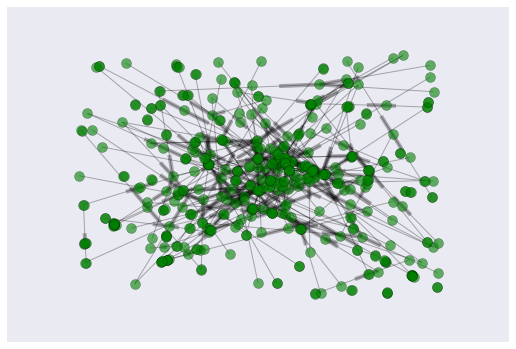

In [14]:
plot_network(g,title="",edgealpha=0.3,node_dist=0.00001,nodesize=100,savefig=True)

# Laplacian Matrix
First 8 rows and columns of laplacian matrix for the graph. Please note that, we round the values in the Laplacian matrix just for demonstration purposes, you should not round these values in real world.

In [15]:
und_g = g.to_undirected()
lpm = nx.laplacian_matrix(und_g)
print(np.round(lpm,2)[0:8,0:8].todense()) 

[[  30.43    0.      0.      0.      0.      0.      0.      0.  ]
 [   0.     12.52    0.      0.      0.      0.      0.      0.  ]
 [   0.      0.     34.21    0.      0.      0.      0.      0.  ]
 [   0.      0.      0.      6.89    0.      0.      0.      0.  ]
 [   0.      0.      0.      0.    100.78    0.      0.      0.  ]
 [   0.      0.      0.      0.      0.     10.12    0.      0.  ]
 [   0.      0.      0.      0.      0.      0.      7.44    0.  ]
 [   0.      0.      0.      0.      0.      0.      0.     26.88]]


# Modularity Matrix
First 8 rows and columns of laplacian matrix for the graph. Please note that, we round the values in the Laplacian matrix just for demonstration purposes, you should not round these values in real world.

In [16]:
modularity_mat = nx.directed_modularity_matrix(g)
print(np.round(modularity_mat,2)[0:8,0:8])

[[ 0.   -0.29 -1.68 -0.42  0.    0.   -0.46  0.  ]
 [ 0.   -0.07 -0.44 -0.11  0.    0.   -0.12  0.  ]
 [ 0.   -0.06 -0.38 -0.1   0.    0.   -0.1   0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.94 -5.58 -1.41  0.    0.   -1.52  0.  ]
 [ 0.   -0.09 -0.56 -0.14  0.    0.   -0.15  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.25 -1.49 -0.38  0.    0.   -0.4   0.  ]]


In [17]:
modulariy_ev = sorted(nx.linalg.spectrum.modularity_spectrum(g),reverse=True)
laplacian_ev = sorted(nx.linalg.spectrum.laplacian_spectrum(und_g),reverse=True)

In [18]:
print('top 10 eigenvalues for modularity matrix and laplacian matrix:')
for k,v in zip(modulariy_ev[0:10],laplacian_ev[0:10]):
    print('modularity matrix: {}\tlaplacian matrix: {}'.format(k,v))

top 10 eigenvalues for modularity matrix and laplacian matrix:
modularity matrix: (30.760687554352245+0j)	laplacian matrix: 1845.8845476947172
modularity matrix: (22.569502100625595+0j)	laplacian matrix: 643.2725952090475
modularity matrix: (21.783120212910404+0j)	laplacian matrix: 576.741834751677
modularity matrix: (15.00837578766052+0j)	laplacian matrix: 451.6681733531664
modularity matrix: (12.323411597370793+0j)	laplacian matrix: 440.086490324746
modularity matrix: (11.618273059953465+0j)	laplacian matrix: 418.4862500196279
modularity matrix: (10.173077132042359+5.663133831362297j)	laplacian matrix: 294.66829434731835
modularity matrix: (10.173077132042359-5.663133831362297j)	laplacian matrix: 250.49447518857863
modularity matrix: (9.28182055084295+0j)	laplacian matrix: 220.41705256805318
modularity matrix: (8.741249743818463+0j)	laplacian matrix: 204.76889419569233


# Modularity value

In [19]:
part = community.best_partition(und_g)
print(community.modularity(part, und_g))

0.893167862975


# Connected Components

In [20]:
sub_graphs = nx.connected_component_subgraphs(und_g)
print('number of connected components: ' + str(len([k for k in sub_graphs])))

number of connected components: 34


# Giant Connected Component

In [21]:
Gc = max(nx.connected_component_subgraphs(und_g), key=len)
Gc=nx.convert_node_labels_to_integers(Gc)
Gc.name='GCC'
print(nx.info(Gc))

Name: GCC
Type: Graph
Number of nodes: 331
Number of edges: 400
Average degree:   2.4169


# Community Detection
We find the communities for the Giant Connected Component

Number of partitions: 331


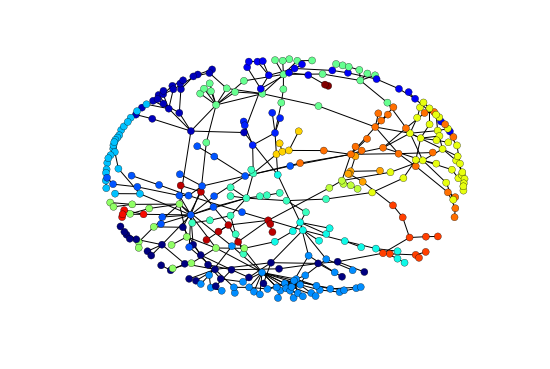

In [22]:
plt.figure(figsize=(9,6))
pos = nx.spring_layout(Gc,iterations=200)
partition = community.best_partition(Gc)
print('Number of partitions: {}'.format(len(partition)))
values = [partition.get(node) for node in Gc.nodes()]
plt.axis("off")
nx.draw_networkx(Gc, pos = pos, cmap = plt.get_cmap("jet"), node_color = values, node_size = 50, with_labels = False)

# Spectral Clustering: Binary Clustering
In binary clustering, we just use the second smallest Eigenvector to decide the labels of nodes.

In [23]:
L = nx.laplacian_matrix(Gc)
eig_values, eig_vectors = np.linalg.eigh(L.todense()) # Eigen values sorted from smallest to biggest

In [24]:
f = eig_vectors[:,1] # use the second smallest Eigen vector for spectral clustering

In [25]:
labels = np.ravel(np.sign(f)) # decides the label of each node

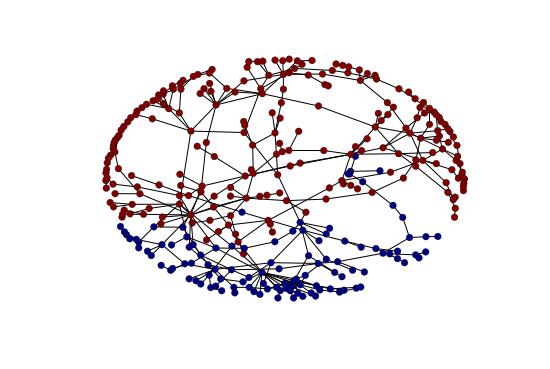

In [26]:
fig = plt.figure(figsize=(9,6))
plt.axis("off")
nx.draw_networkx(Gc, pos,node_size=45, cmap = plt.get_cmap("jet"), node_color=labels, with_labels = False)

# Spectral Clustering: Multiple Clusters
To find more than 2 clusters, we can use all the Eigenvectors (except the first one) of the Laplacian matrix. Please note that these eigenvectors are sorted based on their respective eigenvalues

In [27]:
import scipy.cluster.vq as vq
k=4
means, labels = vq.kmeans2(eig_vectors[:,1:k], k)

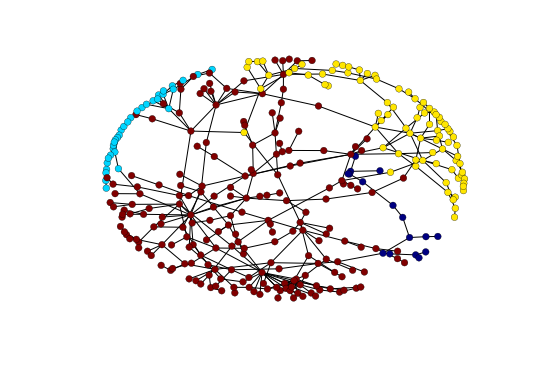

In [28]:
fig = plt.figure(figsize=(9,6))
plt.axis("off")
nx.draw_networkx(Gc, pos, node_size=45, cmap = plt.get_cmap("jet"), node_color=labels, with_labels = False)

# Agglomerative Hierarchical Clustering (AHC)
We use complete link (Creates AHC using farthest point linkage) for this example.

In [29]:
from collections import defaultdict
from scipy.cluster import hierarchy
from scipy.spatial import distance

# LVL 1: Original Graph

original graph (lvl 1) info:
Name: GCC
Type: Graph
Number of nodes: 331
Number of edges: 400
Average degree:   2.4169


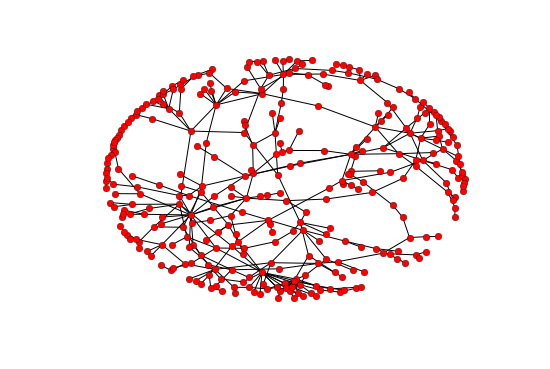

In [30]:
fig=plt.figure(figsize=(9,6))
plt.axis("off")
nx.draw_networkx(Gc, pos, node_size=45, with_labels = False)
print('original graph (lvl 1) info:')
print(nx.info(Gc))

In [31]:
def create_hc(G):
    """Creates hierarchical cluster of graph G from distance matrix"""
    path_length=nx.all_pairs_shortest_path_length(G)
    distances=np.zeros((len(G),len(G)))
    for u,p in path_length.items():
        for v,d in p.items():
            distances[u][v]=d
    # Create hierarchical cluster
    Y=distance.squareform(distances)
    Z=hierarchy.complete(Y)  # Creates HC using farthest point linkage
    # This partition selection is arbitrary, for illustrive purposes
    membership=list(hierarchy.fcluster(Z,t=1.15))
    # Create collection of lists for blockmodel
    partition=defaultdict(list)
    for n,p in zip(list(range(len(G))),membership):
        partition[p].append(n)
    return list(partition.values())

In [32]:
def draw_hc(G, lvl):
    plt.close()
    plt.ion()
    fig=plt.figure(figsize=(9,6))
    plt.axis("off")
    G=nx.convert_node_labels_to_integers(G)
    partitions=create_hc(G)
    BM=nx.blockmodel(G,partitions)
    node_size=[BM.node[x]['nnodes']*10 for x in BM.nodes()]
    edge_width=[1 for (u,v,d) in BM.edges(data=True)]
    pos = nx.spring_layout(BM,iterations=200)
    nx.draw(BM,pos,node_size=node_size,width=edge_width,with_labels=False)
    plt.title('Agglomerative Hierarchical Clustering for Citibike Network, lvl {}'.format(lvl))
    plt.show()
    return BM, partitions

# AGH: level by level clustering

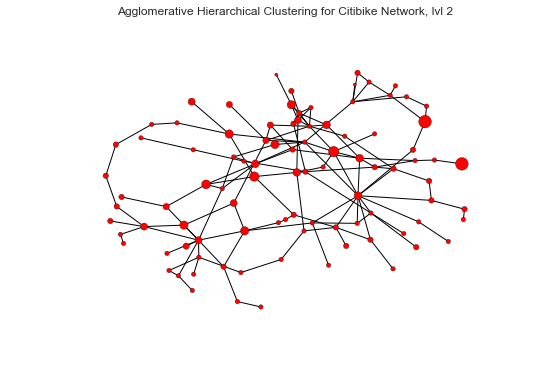

LVL 2 cluster info:
Name: 
Type: Graph
Number of nodes: 95
Number of edges: 139
Average degree:   2.9263
sample of partitions:
[[62, 81, 87, 97, 99, 162, 185, 200, 229, 230, 243, 246, 302, 303, 318, 329], [7, 17, 18, 103, 125, 127, 130, 146, 186, 278, 281, 285, 288, 291, 293, 330], [214, 290], [245, 306], [149, 205, 313]]


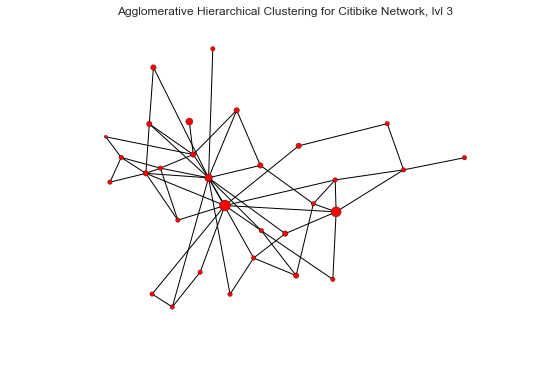

LVL 3 cluster info:
Name: 
Type: Graph
Number of nodes: 31
Number of edges: 57
Average degree:   3.6774
sample of partitions:
[[0, 86, 87, 88, 93], [27, 28, 70], [10, 11, 68], [19, 20], [24, 65]]


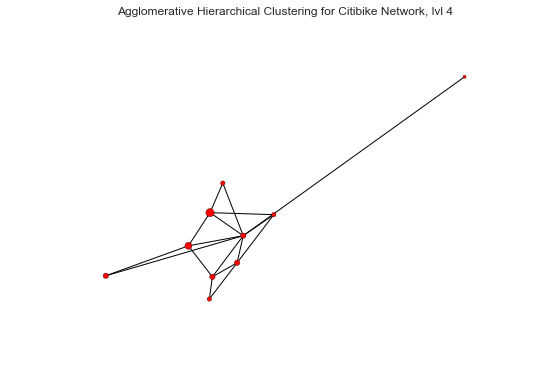

LVL 4 cluster info:
Name: 
Type: Graph
Number of nodes: 10
Number of edges: 17
Average degree:   3.4000
sample of partitions:
[[7, 8, 9, 11, 15], [29, 30], [22, 23, 24], [26, 27], [28]]


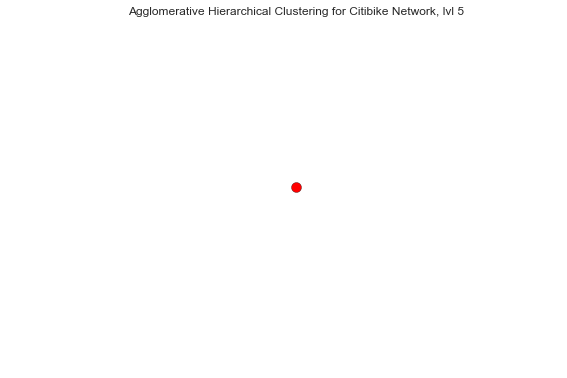

LVL 5 cluster info:
Name: 
Type: Graph
Number of nodes: 1
Number of edges: 0
Average degree:   0.0000
sample of partitions:
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]


In [33]:
H= Gc.copy()
lvl = 2
while(H.number_of_nodes()>1):
    H, partitions = draw_hc(H, lvl)
    print('LVL {} cluster info:'.format(lvl))
    print(nx.info(H))
    print('sample of partitions:')
    print(partitions[0:5])
    lvl +=1

# Divisive Hierarchial Clustering

In [34]:
H = Gc.copy()
partitions = {}
partition_graph = {}
lvl = 1
# adding the original graph as the first lvl
sub_graphs = nx.connected_component_subgraphs(H)
partitions.update({lvl:[k.nodes() for k in sub_graphs]})
while(nx.number_connected_components(H)!=H.number_of_nodes()):
    eb = nx.edge_betweenness(H) # use edge betweenness to find the best edge to remove
    sorted_eb = sorted(eb.items(), reverse=True, key=operator.itemgetter(1))
    k,v = sorted_eb[0][0]
    ncc_before = nx.number_connected_components(H)
    H.remove_edge(k,v)
    ncc_after = nx.number_connected_components(H)
    if ncc_before == ncc_after: continue
    else:
        lvl +=1
        sub_graphs = nx.connected_component_subgraphs(H)
        partitions.update({lvl:[k.nodes() for k in sub_graphs]})
        partition_graph.update({lvl:H.copy()})

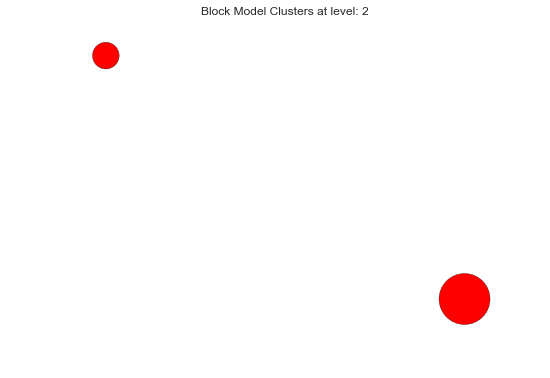

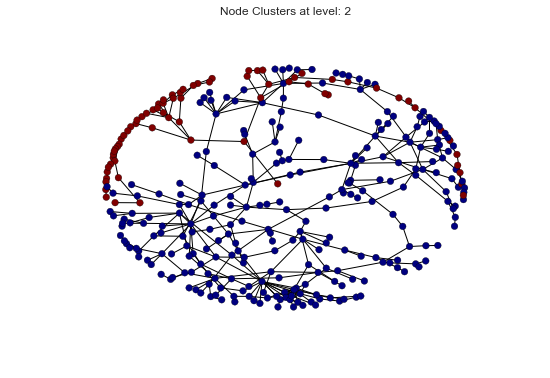

In [36]:
lvl = 2
PG = partition_graph[lvl]
part = partitions[lvl]
labels = np.ones(PG.number_of_nodes())

for i,p in enumerate(part):
    for k in p:
        labels[k]=int(i)

fig = plt.figure(figsize=(9,6))
BM=nx.blockmodel(PG, part)
node_size=[BM.node[x]['nnodes']*10 for x in BM.nodes()]
edge_width=[1 for (u,v,d) in BM.edges(data=True)]
BM_pos = nx.spring_layout(BM,iterations=200)
plt.axis("off")
plt.title("Block Model Clusters at level: {}".format(lvl))
nx.draw(BM, BM_pos,node_size=node_size,width=edge_width,with_labels=False)
fig = plt.figure(figsize=(9,6))
plt.axis("off")
plt.title("Node Clusters at level: {}".format(lvl))
nx.draw_networkx(PG, pos, node_size=45, cmap = plt.get_cmap("jet"), node_color=labels, with_labels = False)